In [2]:
import sys
!{sys.executable} -m pip install pymongo
!{sys.executable} -m pip install pyyaml
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
import os
print(os.getcwd())

/Users/drewgregory/JupyterNotebooks/habitlab-data-analysis


In [3]:
# Get Mongo database
from yaml import load
from pymongo import MongoClient
from getsecret import getsecret

client = MongoClient(getsecret("MONGODB_URI"))
db = client[getsecret("DB_NAME")]

In [4]:
# Get all synced accounts and their respective users.
import urllib.request as req
import json
accounts = json.loads(req.urlopen("http://localhost:5000/synced_emails").read().decode("utf-8"))

In [20]:
# TOTAL AVERAGE COMPARISONS: Organize sessions by goal and frequent vs. infrequent for Android
goals = {}
for account in accounts:
    for user in account["android"]:
        for session in db[user + "_sessions"].find({"enabled": True}):
            domain = session["domain"]
            if domain not in goals:
                goals[domain] = {"freq":[], "infreq":[]}
            if session["frequent"]:
                goals[domain]["freq"].append(session)
            else:
                goals[domain]["infreq"].append(session)

69.77975790181574 133.9029298609056
21.398720682302773 27.119016817593792
67.34920634920636 3510.0454545454545
21 48
44.976190476190474 55.41379310344828
84.37909516380655 99.1972972972973
57.18213507625272 79.31546134663341
75.10157246068849 89.59937800395815
391.3703703703704 73.36842105263158
81.08888888888889 116.23404255319149
50.74324324324324 51.662921348314605
93 611.4347826086956
59.72371818517152 30.465665236051503
148.65217391304347 150.9375
30.301470588235293 28.54901960784314
92.9119496855346 99.75773195876289
217.69263607257204 333.6514806378132
31.053846153846155 53.56666666666667
42.51162790697674 40.887387387387385
79.77586206896552 116.04285714285714
35.804597701149426 37.97345132743363
41.5 85.63157894736842
19.06024096385542 21.06148867313916
22.98148148148148 43.993589743589745
123.33333333333333 156.28
18 30.666666666666668
356 268.75
60.5 216.1818181818182
116.83333333333333 16
225 178.30769230769232
35.5 44.52238805970149
53.282423208191126 45.260149130074566
15

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


92
com.ideashower.readitlater.pro with 45 freq points  and 47 infreq pts
freq avg: 81.08888888888889
infreq avg: 116.23404255319149

93
com.nhn.android.band with 58 freq points  and 35 infreq pts
freq avg: 42.758620689655174
infreq avg: 66.05714285714286

97
com.tindes with 40 freq points  and 57 infreq pts
freq avg: 52.325
infreq avg: 41.12280701754386

100
org.mariotaku.twidere with 25 freq points  and 75 infreq pts
freq avg: 90.84
infreq avg: 78.65333333333334

109
com.rubenmayayo.reddit with 1 freq points  and 108 infreq pts
freq avg: 37
infreq avg: 201.46296296296296

128
com.reddit.frontpage with 58 freq points  and 70 infreq pts
freq avg: 79.77586206896552
infreq avg: 116.04285714285714

138
com.gm99.clx with 69 freq points  and 69 infreq pts
freq avg: 197.68115942028984
infreq avg: 167.92753623188406

141
com.evernote with 84 freq points  and 57 infreq pts
freq avg: 75.1547619047619
infreq avg: 78.85964912280701

163
com.facebook.lite with 74 freq points  and 89 infreq pts
freq

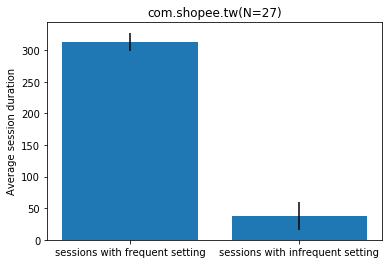

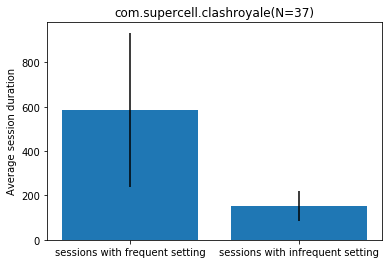

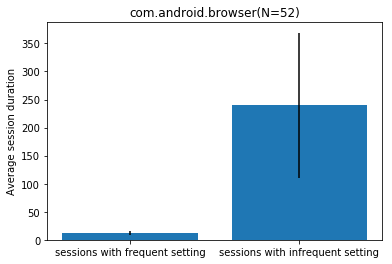

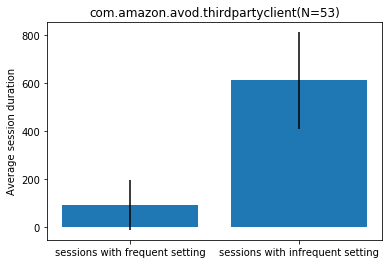

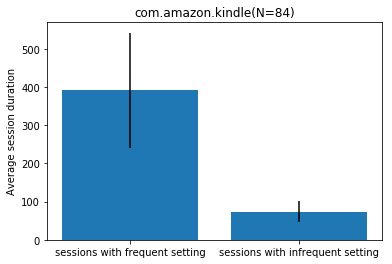

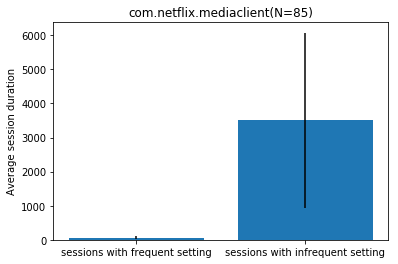

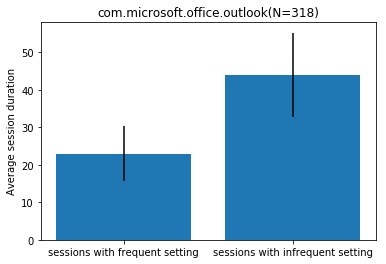

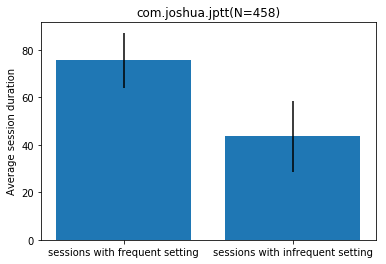

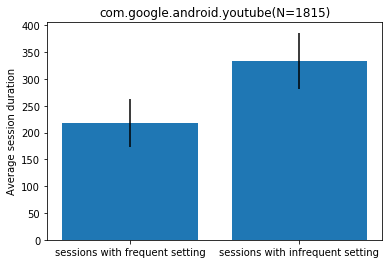

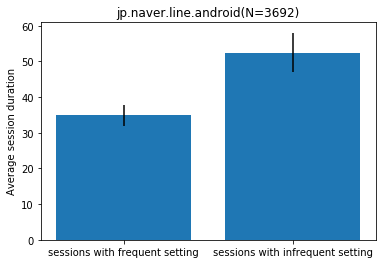

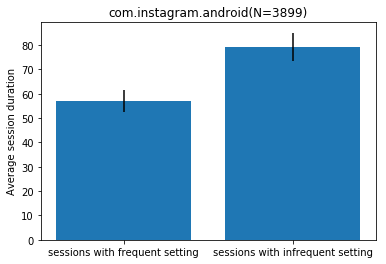

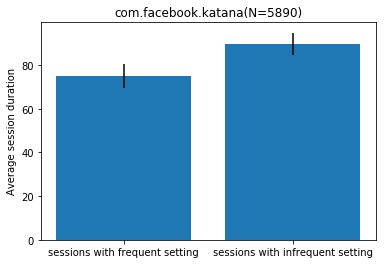

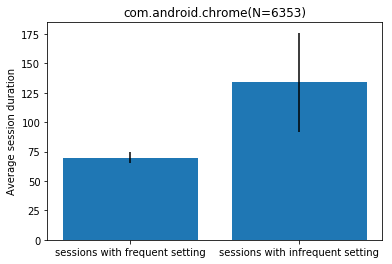

In [21]:
# Graph these comparisons
import matplotlib.pyplot as pyplot
from statistics import mean, median
from scipy.stats import sem, norm 
# Now show graphs for each domain to compare frequent sessions vs infrequent sessions.
domain_stats = []
for domain in goals:
    if len(goals[domain]["freq"]) > 0 and len(goals[domain]["infreq"]) > 0:
        freq_durations = [session["duration"] for session in goals[domain]["freq"]]
        freq_avg = mean(freq_durations)
        freq_err = sem(freq_durations)
        infreq_durations = [session["duration"] for session in goals[domain]["infreq"]] 
        infreq_avg = mean(infreq_durations)
        infreq_err = sem(infreq_durations)
        print(str(freq_avg) + " " + str(infreq_avg))
        domain_stats.append({"domain": domain, "freq": freq_avg, 
                             "infreq": infreq_avg, "freq_pts":len(goals[domain]["freq"]),
                            "infreq_pts":len(goals[domain]["infreq"]), "freq_err": freq_err,
                            "infreq_err": infreq_err})

        domain_stats = sorted(domain_stats, key=lambda stat: int(stat["freq_pts"] + stat["infreq_pts"]))
counter = 0
for stat in domain_stats:
    print(int(stat["freq_pts"] + stat["infreq_pts"]))
    print(stat['domain'] + " with " + str(stat["freq_pts"]) + " freq points " + " and " + str(stat["infreq_pts"]) + " infreq pts")
    print("freq avg: " + str(stat["freq"]))
    print("infreq avg: " + str(stat["infreq"]))
    print("")
    # If there is a statistically significant difference (95% conf intervals don't overlap), we will show the graph.
    if stat["freq"] - 1.64 * stat["freq_err"] > stat["infreq"] + 1.64 * stat["infreq_err"] or stat["infreq"] -  1.64 * stat["infreq_err"] > stat["freq"] + 1.64 * stat["freq_err"]:
        pyplot.figure(counter)
        counter += 1
        pyplot.title(stat["domain"] + "(N="+ str(int(stat["freq_pts"] + stat["infreq_pts"]))+ ")")
        pyplot.ylabel('Average session duration')
        pyplot.bar(["sessions with frequent setting", "sessions with infrequent setting"], [stat["freq"], stat["infreq"]] , .8, yerr=[1.64 * stat["freq_err"], 1.64 * stat["infreq_err"]])
    

In [22]:
# Within user T-Test on freq vs infreq duration length per domain
improvement_stats = {"freq": [], "infreq": []}
for account in accounts:
    for user in account["android"]:
        # We now want to see if they have goals that have alternated from freq to infreq.
        goals={}
        for session in db[user + "_sessions"].find({"enabled": True}):
            domain = session["domain"]
            if domain not in goals:
                goals[domain] = {"freq_duration":0, "freq_count": 0, "infreq_duration":0, "infreq_count":0}
            if session["frequent"]:
                goals[domain]["freq_duration"] += session["duration"]
                goals[domain]["freq_count"] += 1
            else:
                goals[domain]["infreq_duration"] += session["duration"]
                goals[domain]["infreq_count"] += 1
        # Compute averages
        for domain in goals:
            if goals[domain]["freq_count"] > 30 and goals[domain]["infreq_count"] > 30:
                freq_avg = goals[domain]["freq_duration"]/goals[domain]["freq_count"]
                infreq_avg = goals[domain]["infreq_duration"]/goals[domain]["infreq_count"]
                improvement_stats["freq"].append(freq_avg)
                improvement_stats["infreq"].append(infreq_avg)
from scipy.stats import ttest_ind
print(str(len(improvement_stats["freq"])) + " " + str(len(improvement_stats["infreq"])))
results = ttest_ind(improvement_stats["freq"], improvement_stats["infreq"])
print(str(results))

51 51
Ttest_indResult(statistic=-0.644795259691027, pvalue=0.5205363588257785)


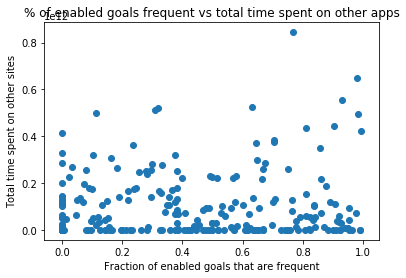

In [35]:
# Goal: fraction of freq goals vs. total time spent
frac = []
total_time_other = []
for account in accounts:
    for user in account["android"]:
        week_stats = {}
        for session in db[user+ "_sessions"].find({"isoWeek": {"$exists": True}, "frequent": {"$exists": True}}):
            iso = session["isoWeek"]
            if iso not in week_stats:
                week_stats[iso] = {"freq": 0, "infreq": 0, "total_time": 0}
            if not session["enabled"]:
                week_stats[iso]["total_time"] += session["duration"]
            elif session["frequent"]:
                week_stats[iso]["freq"] += 1
            else:
                week_stats[iso]["infreq"] += 1
        for iso in week_stats:
            stat = week_stats[iso]
            if stat["infreq"] > 0 or stat["infreq"] > 0:
                frac.append(stat["freq"]/(stat["infreq"] + stat["freq"]))
                total_time_other.append(stat["total_time"])
counter += 1
pyplot.figure(counter)
pyplot.title("% of enabled goals frequent vs total time spent on other apps")
pyplot.xlabel("Fraction of enabled goals that are frequent")
pyplot.ylabel("Total time spent on other sites")
pyplot.scatter(frac, total_time_other)
            


In [36]:
from scipy import stats
stats.linregress(frac, total_time_other)

LinregressResult(slope=29383044596.029404, intercept=89515986667.20529, rvalue=0.06542614652698396, pvalue=0.3148445013312035, stderr=29171444805.76757)